# Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

The client requested an analysis of the actual (old) and the new websites in the  control and experiment groups of users. We will analize the data through an A/B test to help making a decision if the actual pages leads to more or equal conversions of users or not. 

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Read in the `ab_data.csv` dataset


In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. The number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
# A) When the treatment group has an old page
treatm_old = df.query('landing_page == "old_page" & group=="treatment" ')
# B) When the control group has a new page
# We sum both cases
control_new = df.query('landing_page == "new_page" & group=="control"')
treatm_old.count()[0] + control_new.count()[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()
# There are no missing values
# All columns have 294478 values

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` These cases where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, do not have a correct interpretation. It is better to remove them by creating a new dataset **df2** 

In [8]:
treat_new=df.query('landing_page == "new_page" & group=="treatment" ')
control_old=df.query('landing_page == "old_page" & group=="control" ')
df2 = treat_new.append(control_old)
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. Unique **user_id**s in **df2**

In [10]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There are 290584 user_ids and 290585 timestamps. This means ther is one **user_id** repeated in **df2**.  Which is:

In [11]:
df2[df2.duplicated(subset='user_id') ]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. The two rows for the same **user_id**

In [12]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
# for the drop function
# labels : single label or list-like Index or column labels to drop.
# axis : {0 or ‘index’, 1 or ‘columns’}, default 0
df2 = df2.drop(labels=[2893])

In [14]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` The conversion rate regardless of the user page

In [15]:
(df2.query('converted ==1').count() / df2.shape[0])[0]

0.11959708724499628

b. The conversion rate for the `control` group

In [16]:
control_conv_prob = df2.query('converted ==1 & group== "control"').shape[0] / df2.query('group == "control"').shape[0]
control_conv_prob 

0.1203863045004612

c. The conversion rate for the `treatment` group

In [17]:
treat_conv_prob = df2.query('converted ==1 & group== "treatment"').shape[0] / df2.query('group == "treatment"').shape[0]
treat_conv_prob 

0.11880806551510564

d. The probability of receiving the new page

In [18]:
(df2.query('landing_page == "new_page"').count() / df2.shape[0])[0]

0.50006194422266881

 The difference of conversion proportions between old and new page is:

In [19]:
control_conv_prob - treat_conv_prob 

0.0015782389853555567

Due to the small difference between them (less than 1%), there is not sufficient evidence to say that one page leads to more conversions.

Also, being the conversion rate for the treatment group smaller than the conversion rate for the control group, is not sufficient evidence to say the experiment group leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

To continue with the A/B test, let's state the null and the alternative hypotesis.

$ H_0:  P_{new} - P_{old} <= 0 $

$ H_1:  P_{new} - P_{old} > 0 $

a. The **convert rate** for $p_{new}$ under the null

In [20]:
p_new_conv_rate = (df2.query('converted ==1').count() / df2.shape[0])[0]
p_new_conv_rate

0.11959708724499628

b. The **convert rate** for $p_{old}$ under the null <br><br>

In [21]:
p_old_conv_rate = (df2.query('converted ==1').count() / df2.shape[0])[0]
p_old_conv_rate

0.11959708724499628

c. $n_{new}$, the number of users using the new page

In [22]:
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. $n_{old}$, the number of users using the old page

In [23]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old 

145274

e. Simulation of the $n_{new}$ transactions with a convert rate of $p_{new}$ under the null. The 1's represent the 'new page converted' users under the null. The convertion rate of p_new_conv_rate

In [24]:
new_page_converted = np.random.choice([0,1], size=n_new, p= (1-p_new_conv_rate, p_new_conv_rate))
new_page_converted

array([1, 0, 1, ..., 1, 1, 0])

f. Simulation of the $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  The 1's represent the 'old page converted' users under the null. The convertion rate of p_old_conv_rate 

In [25]:
old_page_converted = np.random.choice([0,1], size=n_old, p= (1-p_old_conv_rate, p_old_conv_rate))
old_page_converted

array([1, 0, 0, ..., 0, 0, 0])

g. The difference between $p_{new}$ - $p_{old}$ for the simulated values.

In [26]:
# The number of new_page converted users - old_page converted users, under the null
new_page_converted.mean() - old_page_converted.mean()

0.00047271781700852777

h. Simulation of 10,000 $p_{new}$ - $p_{old}$ values

In [27]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0,1], size=n_new, p= (1-p_new_conv_rate, p_new_conv_rate))
    old_page_converted = np.random.choice([0,1], size=n_old, p= (1-p_old_conv_rate, p_old_conv_rate))
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

p_diffs[0]

0.0014224115751807209

i. Histogram plot of the **p_diffs**.

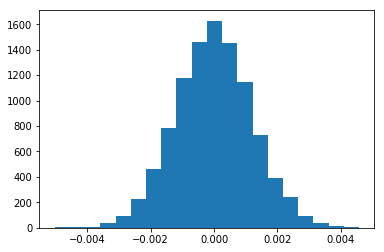

In [28]:
plt.hist(p_diffs, bins=20);

The null hypotesis histogram shows a normally distributed histogram, where the proportion of converted users using the new page is **equal** to the proportion of converted users using the old page. Its mean is zero.

j. The proportion of the **p_diffs** greater than the actual difference observed in **ab_data.csv**

In [29]:
# The difference of convertion proportions observed in df2 is:
obs_diff = treat_conv_prob - control_conv_prob 
obs_diff 

-0.0015782389853555567

The proportion of values greater than the observed difference

In [30]:
p_diffs = np.array(p_diffs)
pvalue = (p_diffs > obs_diff).mean()
pvalue

0.90590000000000004

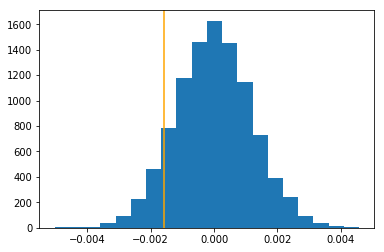

In [31]:
plt.hist(p_diffs, bins=20)
plt.axvline(obs_diff, color = 'orange');

We just calculated the **p-value**: the proportion of values which in the null hypothesis are greater than the observed value (the difference of conversion proportions observed in df2)

The p-value is rounded to 0.9003, which represents **90.03%** of the null hypotesis values. Since it is greater than the 5% threshold, **we fail to reject the null hypothesis** and say that **there is no such relation between the conversion rates and the group (control or experimental).** 

#### Built-in T- test

l. Being `n_old` and `n_new` the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm
 
convert_old = df2.query('converted ==1 & group== "control"').shape[0] 
convert_new = df2.query('converted ==1 & group== "treatment"').shape[0] 


m. We'll use `stats.proportions_ztest` to compute the test statistic and p-value. 

In [34]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

(-1.3109241984234394, 0.90505831275902449)

The values obtained with the ztest are concordant with the bootstrapped hypotesis test.

<a id='regression'></a>
### Part III - A regression approach

 **Logistic Regression** can show show us the same results as the previous A/B test.<br><br>


b. First we create a column for the dummy variable named **ab_page** for which page each user received. In this column, 1 represents the **treatment** and 0 the **control** page.
Also a column for the **intercept**.


In [35]:
df2[['ab_page','old_page']] = pd.get_dummies(df2['landing_page'])
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page,intercept
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1


c. Using **statsmodels** we're going to instantiate and fit the model using intercept and ab_page columns, to predict whether or not an individual converts.

In [36]:
log_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. The summary of the model

In [38]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Oct 2018   Pseudo R-squ.:               8.077e-06
Time:                        16:40:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p-value for the ab_page is **0.19**, which is greater than the $\alpha = $**0.05**, for which we reject the null hypothesis.
The p-value is different for a two-tailed test.

It is convenient to explore some other factors into the model, to see if there are significant effects in the conversion of users. Now we'll add the country variable.

#### Considering an additional variable for the model
g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [36]:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [37]:
df3 = countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df3.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


The values for country

In [38]:
df3['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

#### Create a model based on user's countries

Prepare for the model. Create the dummies for country, and the intercept.

In [39]:
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


Instantiate and fit the model using intercept and country.

In [40]:
df3['intercept'] = 1
log_mod2 = sm.Logit(df3['converted'], df3[['intercept','UK', 'US']])
results2 = log_mod2.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [41]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 15 Oct 2018   Pseudo R-squ.:               1.521e-05
Time:                        18:39:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

The p-values shown for the countries are still greater than 0.05, which make them irrelevant to predict whether or not an individual converts.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

#### Create a model with interactions 

With the purpose of exploring if the response is not linearly related to the response (the conversion), and has higher order terms, we'll create a model based in interactions between the assigned page and the country.

Instantiate and fit the model using intercept, country, and page.

In [51]:
df3['US_page'] = df3['US'] * df3['ab_page']
df3['UK_page'] = df3['UK'] * df3['ab_page']
df3.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept,CA,UK,US,CA_page,UK_page,US_page
user_id,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,0,1,0


In [53]:
df3['intercept'] = 1
log_mod3 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'US', 'UK', 'US_page', 'UK_page']])
result3 = log_mod3.fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 15 Oct 2018   Pseudo R-squ.:               3.482e-05
Time:                        16:59:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US_page        0.0469      0.054      0.872      0.383      -0.059       0.152
UK_page        0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

<a id='conclusions'></a>

As we can check, all of the p-value coeficients are irrelevant for the response on the conversion of users.

We fail to reject the null hypotesis, since there is not enough evidence to propose that either landing page or country affects the response on the number of users conversions.


### Other sources

Documentation on pandas

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html

Documentation on LaTeX

https://tex.stackexchange.com/questions/216358/using-mathematical-symbols-alpha-beta-implies-in-latex

Documentation on matplotlib

https://matplotlib.org/api/index.html


In [2]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0